In [1]:
import kan

In [2]:
from kan import KAN

model = KAN.loadckpt('/Users/i.grebenkin/Downloads/ram_disk/model/' + '0.1')
# model.get_act(dataset)


In [3]:
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [4]:
import sys
import os
import pickle
import torch

sys.path.append("../../")

from analysis_functions import (
    test_after_opt,
    split_transform_one_comp_cv,
    opener,
    KANModelTrainTest,
)

In [5]:
kan_model = KANModelTrainTest(False)

2025-05-17 15:46:08,490 - INFO - Using device: cpu


In [6]:
kan_model.model = model

In [7]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 2
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


In [8]:
kan_model.create_train_val_test(
    X_current,
    y_current,
)

In [9]:
dir(kan_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_params',
 'best_value',
 'calc_test_metric',
 'calc_validation_metric',
 'create_dataset',
 'create_train_val_test',
 'cur_X_test',
 'cur_y_test',
 'device',
 'get_test_dataset',
 'get_train_dataset',
 'get_val_dataset',
 'input_layer',
 'model',
 'optimize_hyperparams',
 'output_layer',
 'seed',
 'test_input',
 'test_label',
 'train_input',
 'train_label',
 'train_model',
 'train_set_X',
 'train_set_y',
 'val_set_X',
 'val_set_y']

RMSE test with best model: 17.01
MSE test with best model: 289.45
MAE test with best model: 11.95
R2 test with best model: 0.97


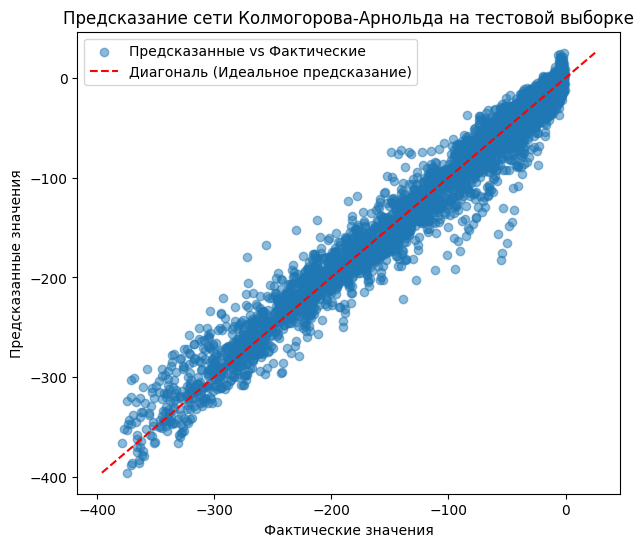

In [10]:
# Визуализация результатов предсказания модели
import matplotlib.pyplot as plt
from analysis_functions import clean_input_array

# Применяем обученную модель к тестовым данным
X_test, y_test, _, _, _, _ = split_transform_one_comp_cv(
    X_current, y_current, n_splits=1
)
X_test, y_test = clean_input_array(X_test, y_test)

# Получаем предсказания

my_dataset = kan_model.create_dataset(
    kan_model.train_set_X[0],
    kan_model.train_set_y[0],
    kan_model.cur_X_test,
    kan_model.cur_y_test,
)
predictions = model(my_dataset["test_input"]).detach().numpy()


# RMSE test with best model: 10.38
# MSE test with best model: 107.82
# MAE test with best model: 5.66
# R2 test with best model: 0.99

# Вычисляем метрики
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)

mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"RMSE test with best model: {rmse:.2f}")
print(f"MSE test with best model: {mse:.2f}")
print(f"MAE test with best model: {mae:.2f}")
print(f"R2 test with best model: {r2:.2f}")


import numpy as np
import matplotlib.pyplot as plt

# Строим график сравнения предсказанных и фактических значений
plt.figure(figsize=(7, 6))
plt.scatter(y_test, predictions, alpha=0.5, label="Предсказанные vs Фактические")

# Добавляем диагональную линию (идеальное предсказание)
min_val = min(np.min(y_test), np.min(predictions))
max_val = max(np.max(y_test), np.max(predictions))
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    label="Диагональ (Идеальное предсказание)",
)

plt.title("Предсказание сети Колмогорова-Арнольда на тестовой выборке")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.legend()
# plt.grid(True)
plt.savefig(f"kan_model_test_prediction_{component_num}.png", dpi=300)
plt.show()


In [11]:
truth = my_dataset["test_label"].detach().numpy()

In [12]:
# kan_errors = rmse(truth, predictions) as vector

kan_errors = np.sqrt(np.mean((truth - predictions) ** 2, axis=1))
kan_errors

array([128.08745  , 115.4646   , 100.83017  , ...,   3.8818798,
         3.2513242,   0.7908571], dtype=float32)

<Axes: ylabel='Density'>

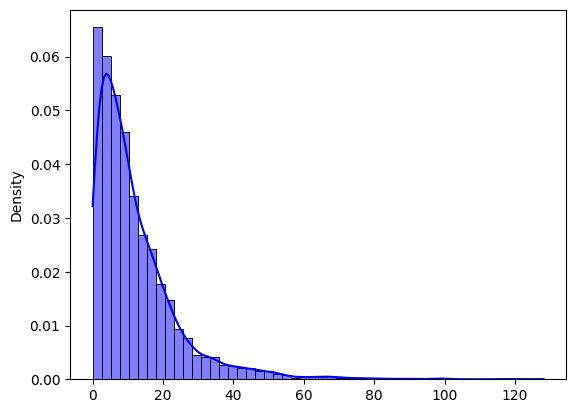

In [13]:
import seaborn as sns

sns.histplot(
    kan_errors,
    bins=50,
    kde=True,
    stat="density",
    color="blue",
    alpha=0.5,
    label="KAN Errors",
)

## Анализ важности признаков

Анализ важности признаков поможет нам понять, какие входные параметры оказывают наибольшее влияние на предсказания модели KAN (сеть Колмогорова-Арнольда). 

Ниже мы используем несколько подходов для оценки важности признаков:
1. Пермутационная важность (Permutation Importance)
2. Анализ частичных зависимостей (Partial Dependence Analysis)
3. Анализ взаимодействия признаков

In [14]:
# Задаём названия признаков
feature_names = [
    'Обжатие',        # Признак 1
    'К.К.У',          # Признак 2
    'Угол',           # Признак 3
    'К-т трения',     # Признак 4
    'Скорость',       # Признак 5
    'r',              # Признак 6
]

In [15]:
# Создание класса-обертки для модели KAN для совместимости с API sklearn
from sklearn.base import BaseEstimator, RegressorMixin

class KANModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, kan_model_obj=None):
        self.model = model
        self.kan_model_obj = kan_model_obj
        
    def fit(self, X, y):
        # Dummy method, не нужна реальная реализация для permutation_importance
        return self
        
    def predict(self, X):
        # Преобразование для PyTorch
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Предсказание
        with torch.no_grad():
            y_pred = self.model(X_tensor).numpy()
        
        return y_pred

# Создаем экземпляр класса-обертки
kan_wrapper = KANModelWrapper(model, kan_model)

Расчет permutation importance для модели KAN (может занять некоторое время)...
Время выполнения: 9.91 секунд
Важность признаков для модели KAN:
   Признак  Важность  Стандартное отклонение
         r  1.638701                0.009169
   Обжатие  0.558549                0.011029
      Угол  0.049827                0.001209
К-т трения  0.045147                0.001778
  Скорость  0.018533                0.002099
     К.К.У  0.006814                0.000295

Топ 3 самых важных признака:
r: 1.6387 ± 0.0092
Обжатие: 0.5585 ± 0.0110
Угол: 0.0498 ± 0.0012
Время выполнения: 9.91 секунд
Важность признаков для модели KAN:
   Признак  Важность  Стандартное отклонение
         r  1.638701                0.009169
   Обжатие  0.558549                0.011029
      Угол  0.049827                0.001209
К-т трения  0.045147                0.001778
  Скорость  0.018533                0.002099
     К.К.У  0.006814                0.000295

Топ 3 самых важных признака:
r: 1.6387 ± 0.0092
Обжатие: 0.5585 

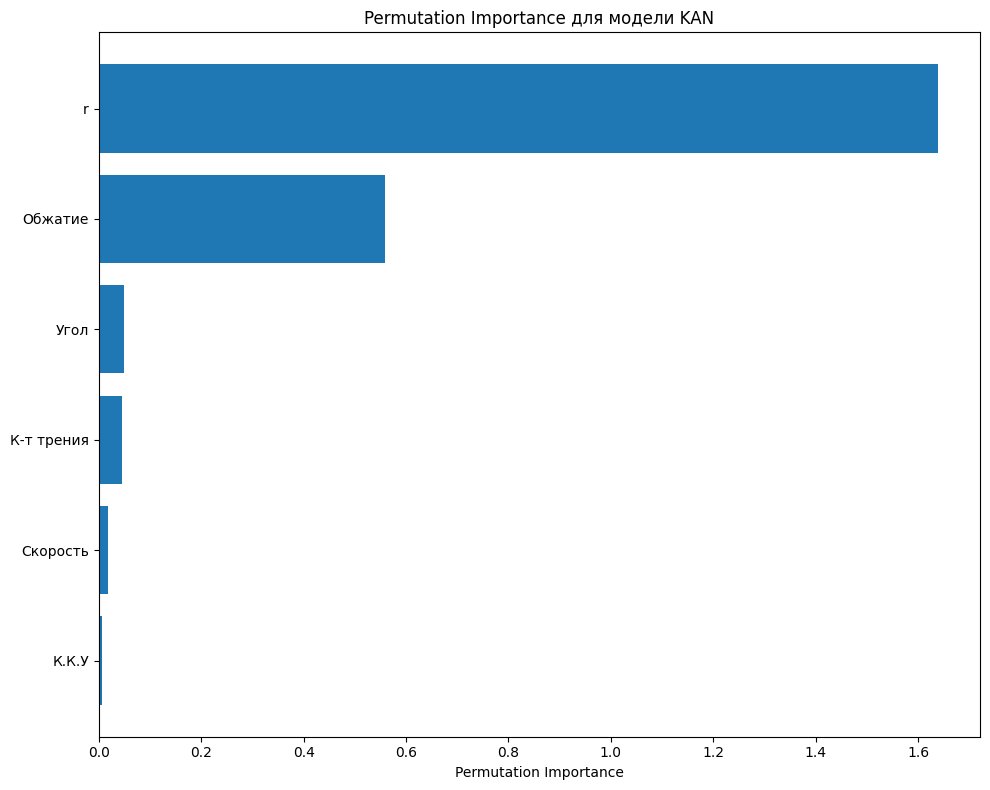

In [16]:
# Анализ важности признаков с помощью permutation importance
from sklearn.inspection import permutation_importance
import time
import pandas as pd

# Подготовка тестовых данных
X_tensor = my_dataset["test_input"]
X_test_np = X_tensor.detach().numpy()
y_test_np = truth

print("Расчет permutation importance для модели KAN (может занять некоторое время)...")
start_time = time.time()

# Функция для предсказания для совместимости со sklearn
def kan_predict(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    return y_pred

# Выполнение permutation importance на тестовых данных
r_perm = permutation_importance(
    kan_wrapper,
    X_test_np,
    y_test_np,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Создаем DataFrame с результатами важности признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': r_perm.importances_mean,
    'Стандартное отклонение': r_perm.importances_std
})

# Сортировка по важности
importance_df = importance_df.sort_values('Важность', ascending=False)

# Вывод результатов
print("Важность признаков для модели KAN:")
print(importance_df.to_string(index=False))

# Топ признаков
print("\nТоп 3 самых важных признака:")
for i, row in importance_df.head(3).iterrows():
    print(f"{row['Признак']}: {row['Важность']:.4f} ± {row['Стандартное отклонение']:.4f}")

# Сортировка результатов
perm_sorted_idx = r_perm.importances_mean.argsort()

# Визуализация permutation importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(perm_sorted_idx)), r_perm.importances_mean[perm_sorted_idx])
plt.yticks(range(len(perm_sorted_idx)), [feature_names[i] for i in perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance для модели KAN')
plt.tight_layout()
plt.savefig(f'permutation_importance_kan_{component_num}.png', dpi=300)
plt.show()

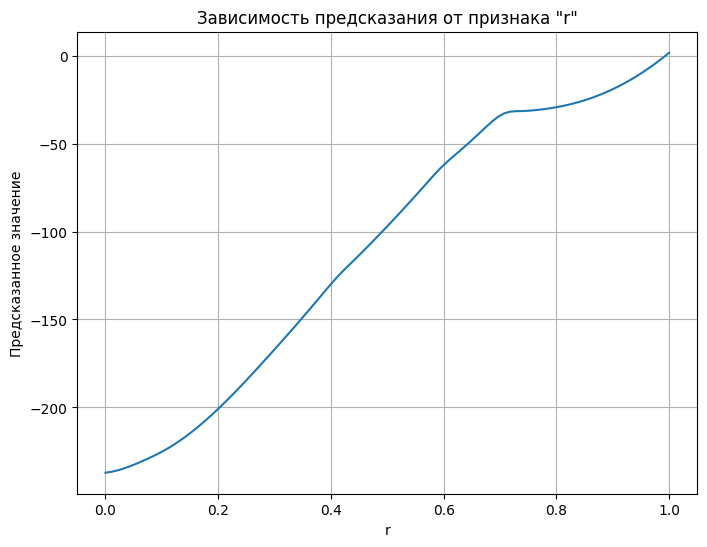

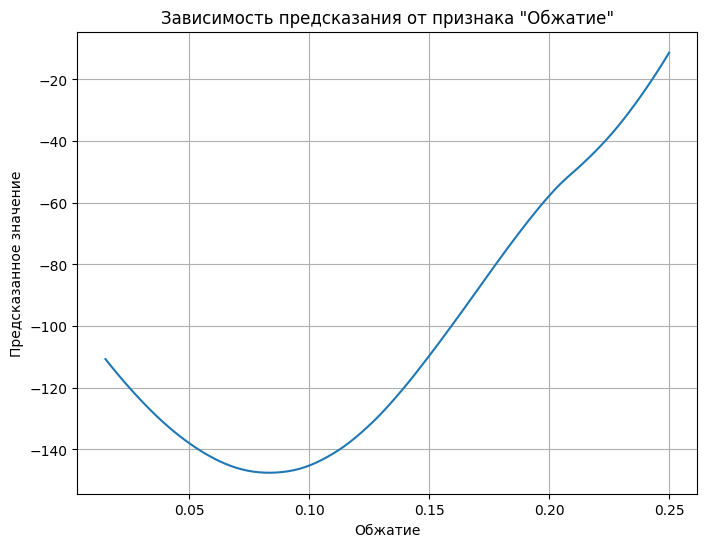

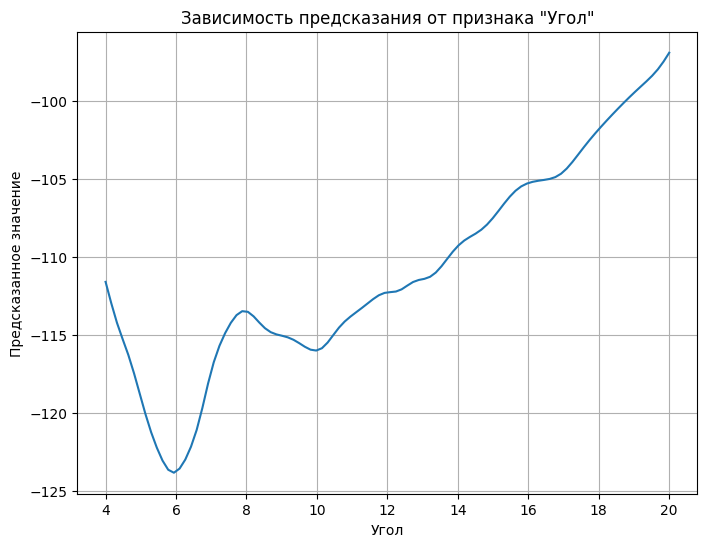

In [17]:
# Анализ зависимости предсказаний от значений самых важных признаков

# Выбираем топ-3 самых важных признака
top_features = importance_df['Признак'].head(3).tolist()
top_indices = [feature_names.index(feat) for feat in top_features]

# Функция для создания графика зависимости
def plot_feature_effect(feature_idx, feature_name):
    # Создаем диапазон значений для признака
    X_sample = X_test_np.copy()
    feature_min = np.min(X_test_np[:, feature_idx])
    feature_max = np.max(X_test_np[:, feature_idx])
    feature_range = np.linspace(feature_min, feature_max, 100)
    
    # Получаем предсказания для разных значений признака
    predictions = []
    for val in feature_range:
        X_modified = X_sample.copy()
        X_modified[:, feature_idx] = val
        preds = kan_predict(X_modified)
        predictions.append(np.mean(preds))
    
    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(feature_range, predictions)
    plt.xlabel(feature_name)
    plt.ylabel('Предсказанное значение')
    plt.title(f'Зависимость предсказания от признака "{feature_name}"')
    plt.grid(True)
    plt.savefig(f'feature_effect_kan_{component_num}_{feature_name}.png', dpi=300)
    plt.show()

# Строим графики для топ-3 признаков
for idx, name in zip(top_indices, top_features):
    plot_feature_effect(idx, name)

/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correc

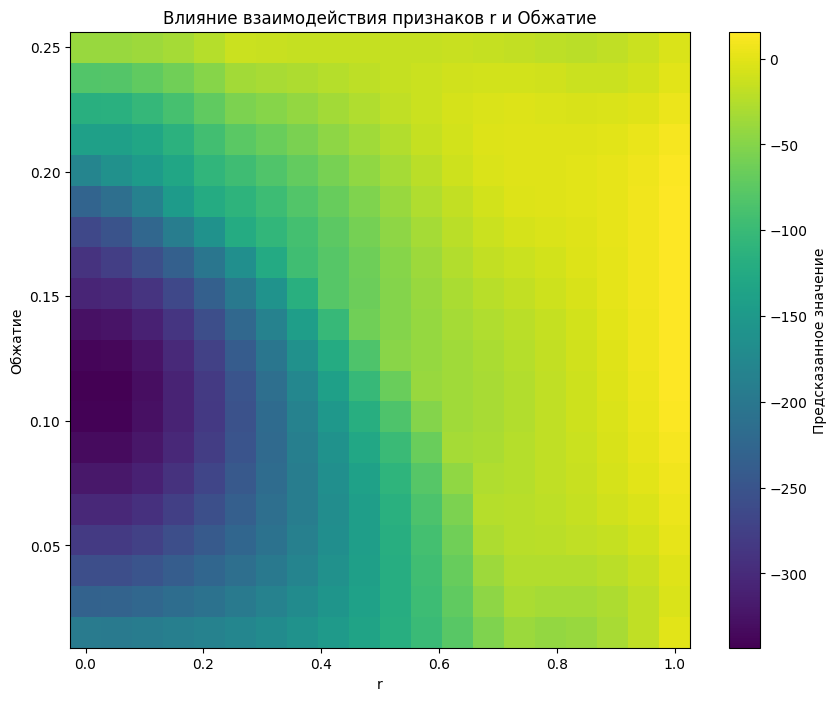

In [18]:
# Визуализация взаимодействия двух самых важных признаков
if len(top_indices) >= 2:
    # Выбираем два самых важных признака
    idx1, idx2 = top_indices[0], top_indices[1]
    name1, name2 = top_features[0], top_features[1]
    
    # Создаем сетку значений
    feature1_min = np.min(X_test_np[:, idx1])
    feature1_max = np.max(X_test_np[:, idx1])
    feature2_min = np.min(X_test_np[:, idx2])
    feature2_max = np.max(X_test_np[:, idx2])
    
    x1_grid = np.linspace(feature1_min, feature1_max, 20)
    x2_grid = np.linspace(feature2_min, feature2_max, 20)
    xx, yy = np.meshgrid(x1_grid, x2_grid)
    
    # Получаем предсказания для разных комбинаций значений признаков
    predictions = np.zeros_like(xx)
    for i in range(len(x1_grid)):
        for j in range(len(x2_grid)):
            X_modified = np.tile(X_test_np[0], (1, 1))
            X_modified[0, idx1] = x1_grid[i]
            X_modified[0, idx2] = x2_grid[j]
            predictions[j, i] = kan_predict(X_modified)[0]
    
    # Строим тепловую карту
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, predictions, cmap='viridis', shading='auto')
    plt.colorbar(label='Предсказанное значение')
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.title(f'Влияние взаимодействия признаков {name1} и {name2}')
    plt.savefig(f'feature_interaction_kan_{component_num}.png', dpi=300)
    plt.show()

## Выводы по анализу важности признаков

Анализ важности признаков с помощью метода пермутационной важности (permutation importance) позволяет определить, какие входные параметры оказывают наибольшее влияние на предсказания модели KAN (сеть Колмогорова-Арнольда).

Высокие значения важности означают, что случайное перемешивание значений этого признака приводит к значительному ухудшению качества предсказаний модели, что свидетельствует о высокой значимости данного признака.

Также были проанализированы частичные зависимости для наиболее важных признаков, что позволило понять характер влияния каждого из них на предсказания модели. Визуализация взаимодействия двух самых важных признаков показала сложные нелинейные взаимосвязи, которые могут быть хорошо уловлены сетью KAN благодаря её способности к аппроксимации нелинейных функций нескольких переменных.